In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms


In [2]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Current device is', device)

# for reproducibility
torch.manual_seed(2023)
if device == 'cuda':
    torch.cuda.manual_seed_all(2023)

Current device is cuda


In [3]:
import shutil
import os

# 손상된 캐시 폴더 삭제
cache_dir = os.path.expanduser("~/.cache/kagglehub")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("KaggleHub cache deleted.")


KaggleHub cache deleted.


In [5]:
import kagglehub

path = kagglehub.dataset_download("andrewmvd/metastatic-tissue-classification-patchcamelyon")
print("Path to dataset files:", path)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7.47G/7.47G [11:37<00:00, 11.5MB/s]

Extracting files...


Path to dataset files: C:\Users\roobe\.cache\kagglehub\datasets\andrewmvd\metastatic-tissue-classification-patchcamelyon\versions\9


In [6]:
import os

# 사용자 홈 기준으로 자동 경로 설정
base_path = os.path.expanduser("~/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon")

# 모든 하위 버전 디렉토리 확인
for root, dirs, files in os.walk(base_path):
    print("📁", root)
    for f in files:
        print("   └─", f)


📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon
   └─ 9.complete
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon\versions
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon\versions\9
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon\versions\9\camelyonpatch_level_2_split_train_mask
   └─ camelyonpatch_level_2_split_train_mask.h5
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon\versions\9\Labels
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon\versions\9\Labels\Labels
   └─ camelyonpatch_level_2_split_test_y.h5
   └─ camelyonpatch_level_2_split_train_y.h5
   └─ camelyonpatch_level_2_split_valid_y.h5
📁 C:\Users\roobe/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-pa

In [7]:
import os
import h5py

# Windows 사용자 홈 디렉토리 기준 경로
data_dir = os.path.expanduser("~/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon/versions/9/pcam")
h5_file = os.path.join(data_dir, "training_split.h5")

# HDF5 파일 내부 키 확인
with h5py.File(h5_file, "r") as file:
    print("✅ HDF5 파일 로드 성공!")
    print("📂 포함된 키 목록:", list(file.keys()))


✅ HDF5 파일 로드 성공!
📂 포함된 키 목록: ['x']


In [8]:
import h5py
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

import matplotlib.pyplot as plt

In [9]:
# HDF5 데이터셋 클래스 정의
from torch.utils.data import Dataset
import h5py
import numpy as np
from PIL import Image

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), #과적합 방지 위해서 뒤집은 데이터도 학습-> 데이터 늘림
    transforms.RandomRotation(10),#과적합 방지 위해서 데이터 10도 회전시켜서 학습
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


class HDF5Dataset(Dataset):
    def __init__(self, image_h5_path, label_h5_path, transform=None):
        self.image_h5_path = image_h5_path
        self.label_h5_path = label_h5_path
        self.transform = transform

        # 파일 핸들을 유지하지 않음 — 대신 길이 정보만 가져옴
        with h5py.File(self.image_h5_path, "r") as img_file:
            self.length = len(img_file["x"])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # 파일을 매번 열고 필요한 인덱스만 읽기
        with h5py.File(self.image_h5_path, "r") as img_file:
            image = img_file["x"][idx]   #원래 코드는 with h5py.File(self.image_h5_path, "r") as img_file, h5py.File(self.label_h5_path, "r") as lbl_file:
                                         #self.images = img_file["x"][:]  
                                         #self.labels = lbl_file["y"][:]->이미지 한번 읽을 때마다 전체 데이터와 레이블을 읽음->용량이 많이 필요  
        with h5py.File(self.label_h5_path, "r") as lbl_file:
            label = lbl_file["y"][idx]#바뀐 방식은 한번에 한장씩 필요한 레이블가 인ㄷㄱ스만 읽음

        image = Image.fromarray(image.astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label



# 데이터셋 경로 설정
# 경로 수정
data_dir = os.path.expanduser("~/.cache/kagglehub/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon/versions/9")
image_dir = os.path.join(data_dir, "pcam")  # ✅ 여기까지만
label_dir = os.path.join(data_dir, "Labels", "Labels")  # ✅ 그대로 유지


# 학습 데이터 로드
train_dataset = HDF5Dataset(
    image_h5_path=os.path.join(image_dir, "training_split.h5"),
    label_h5_path=os.path.join(label_dir, "camelyonpatch_level_2_split_train_y.h5"),  # 수정된 레이블 경로
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 검증 데이터 로드
val_dataset = HDF5Dataset(
    image_h5_path=os.path.join(image_dir, "validation_split.h5"),
    label_h5_path=os.path.join(label_dir, "camelyonpatch_level_2_split_valid_y.h5"),  # 수정된 레이블 경로
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 테스트 데이터 로드
test_dataset = HDF5Dataset(
    image_h5_path=os.path.join(image_dir, "test_split.h5"),
    label_h5_path=os.path.join(label_dir, "camelyonpatch_level_2_split_test_y.h5"),  # 수정된 레이블 경로
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 데이터 개수 확인
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 262144
Validation dataset size: 32768
Test dataset size: 32768


In [15]:
import torch
import torch.nn as nn
from torchvision.models import vgg16

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current device is', device)

# reproducibility
torch.manual_seed(2023)
if device == 'cuda':
    torch.cuda.manual_seed_all(2023)

# hyperparameters
learning_rate = 0.01
epochs = 5

# model
model = vgg16().to(device)

# loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(model)


Current device is cuda
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2

In [16]:
train_batch = len(train_loader)
val_batch = len(val_loader)

In [17]:
print('Learning started.')

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

best_val_loss = 10**9           # 초기값을 매우 큰 값으로 설정
patience_limit = 3              # 최대 몇 번의 epoch까지 개선 없음을 허용할지
patience_check = 0              # 현재 몇 epoch 연속으로 개선되지 않았는지

for epoch in range(epochs): # Use 'epochs' instead of 'epoch'
    # training
    train_loss = 0
    correct = 0

    for X, Y in train_loader:
        # image is already size of (1, 28, 28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device).squeeze()

        optimizer.zero_grad()
        Y_pred = model.forward(X)
        loss = criterion(Y_pred,Y)
        loss.backward()
        optimizer.step()

        train_loss += loss / train_batch

        correct_prediction = torch.argmax(Y_pred, 1) == Y
        correct += correct_prediction.sum()

    train_acc = (100*correct/len(train_loader.dataset))
    train_acc_list.append(train_acc.item())
    train_loss_list.append(train_loss.item())


    # validation
    with torch.no_grad(): #validation 에서는 gardient 업데이트x
        val_loss = 0
        correct = 0

        for X, Y in val_loader:
            X_val = X.to(device)
            Y_val = Y.to(device).squeeze()

            Y_pred = model.forward(X_val)
            loss = criterion(Y_pred, Y_val)

            val_loss += loss / val_batch

            correct_prediction = torch.argmax(Y_pred, 1) == Y_val
            correct += correct_prediction.sum()

        val_acc = (100*correct/len(val_loader.dataset))
        val_acc_list.append(val_acc.item())
        val_loss_list.append(val_loss.item())

    print("[Epoch %2d] loss %.4f  acc %.2f, val loss %.4f  val acc %.2f"
          % (epoch+1, train_loss, train_acc, val_loss, val_acc))

     # ----------------- Early Stopping -----------------
    if val_loss > best_val_loss:
        patience_check += 1
        if patience_check >= patience_limit:
            print('Early Stopping!')
            break
    else:
        best_val_loss = val_loss
        patience_check = 0

print('Learning Finished!')  

Learning started.
[Epoch  1] loss 0.5620  acc 73.50, val loss 0.4634  val acc 79.41
[Epoch  2] loss 0.4170  acc 81.49, val loss 0.4158  val acc 81.70
[Epoch  3] loss 0.3748  acc 83.65, val loss 0.3876  val acc 83.02
[Epoch  4] loss 0.3360  acc 85.68, val loss 0.3465  val acc 85.32
[Epoch  5] loss 0.2976  acc 87.62, val loss 0.3499  val acc 84.74
Learning Finished!


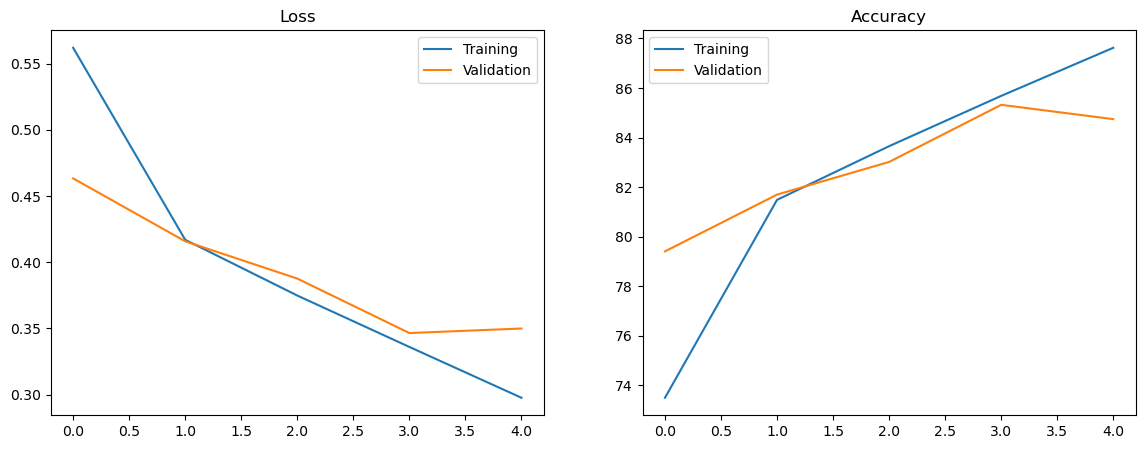

In [18]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(range(len(train_loss_list)), train_loss_list, range(len(val_loss_list)), val_loss_list)
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(range(len(train_acc_list)), train_acc_list, range(len(val_acc_list)),val_acc_list)
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.show()

In [19]:
with torch.no_grad():
    correct = 0
    for X, Y in test_loader:
        X_test = X.to(device)
        Y_test = Y.to(device).view(-1).long()  # <-- 중요

        Y_pred = model.forward(X_test)
        prediction = torch.argmax(Y_pred, 1)
        correct_prediction = prediction == Y_test
        correct += correct_prediction.sum().item()

    accuracy = correct / len(test_loader.dataset) * 100
    print('Test set Accuracy: %.2f' % accuracy)


Test set Accuracy: 85.10


In [ ]:
print("Length of test dataset:", len(test_loader.dataset))


In [30]:
print("Y_test dtype:", Y_test.dtype)
print("Y_test shape:", Y_test.shape)
print("Y_test sample:", Y_test[:5])


Y_test dtype: torch.uint8
Y_test shape: torch.Size([16, 1, 1, 1])
Y_test sample: tensor([[[[0]]],


        [[[1]]],


        [[[1]]],


        [[[1]]],


        [[[1]]]], device='cuda:0', dtype=torch.uint8)
